# Libraries needed

In [1]:
# Import basic libraries
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Plotting libraries
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt

# Start client
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42597,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://127.0.0.1:40501,Total threads: 1
Dashboard: /proxy/37929/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:40751,


# Monthly averaged data

In [2]:
path_era5_monthly = '/g/data/rt52/era5/single-levels/monthly-averaged/'

In [3]:
# These are the directory names, concatonated on the path above
variables = ['2t', 'mtpr', '10u', '10v', 'msdrswrf', 'aluvp']

- Open concatenated datasets:

In [4]:
# data is an empty dictionary
data = {}
# loop for the list in variables 
for v in variables:
    print('Opening: '+v)
    # loop through all directories to find the data files required over multiple years
    listv = np.sort(glob.glob(path_era5_monthly+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv)
    print('Opened')
data['sns'] = (1 - data['aluvp']['aluvp'])*data['msdrswrf']['msdrswrf']
data['wind'] = np.sqrt(data['10u']['u10']**2+data['10v']['v10']**2).rename('wind')

Opening: 2t
Opened
Opening: mtpr
Opened
Opening: 10u
Opened
Opening: 10v
Opened
Opening: msdrswrf
Opened
Opening: aluvp
Opened


- Extract the locations of interest and put them in a dataarray:

In [5]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

- Get nearest point in ERA5 for all variables (removing u10 and v10 from the list because we don't want them):

In [ ]:
for v in ['2t', 'mtpr', 'wind', 'msdrswrf', 'aluvp', 'sns']:
    for var_name in data[v].data_vars:
        ext = data[v][var_name].sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
        extracted_data[v] = xr.DataArray(ext, 
                                         dims = {'index', 'time'}, 
                                         coords = {'index':extracted_data['index'], 'time':data[v]['time']}).rename(v)

- Replace negative values in rainfall with 0

In [ ]:
extracted_data['mtpr'] = xr.where(old_ncfile['mtpr']<0, 0, old_ncfile['mtpr'])

- Add land mask.
For this, we open a variable that we know is masked. In this case, wind.
Open just one file, we don't care about time variations

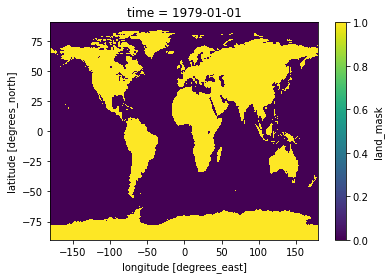

In [9]:

mask = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/wind/1979/wind_era5_moda_sfc_19790101-19790131.nc')['wind']
mask = xr.where(np.isnan(mask), 1, 0).rename('land_mask')
mask.plot()

In [ ]:
ext = mask.sel(longitude = extracted_data['long'], latitude = extracted_data['lat'], method = 'nearest')
extracted_data['land_mask'] = xr.DataArray(ext, 
                                           dims = {'index'}, 
                                           coords = {'index':extracted_data['index']})

In [11]:
# write out the data
# This data DOESN'T have Tmax, Tmin, or RH. Go to last section in this notebook for that.
extracted_data.to_netcdf('ERA5-monthly_averaged.nc')

# Daily averaged data

In [2]:
df = pd.read_csv('/g/data/e14/jn8053/andy-pitman/islands_AUS_export.csv')
locations = df.to_xarray()
extracted_data = xr.Dataset(data_vars = {'ulm_ID':locations['ulm_ID'],'long':locations['long'],'lat':locations['lat']})

- Load the required Lat & Long coordinates
- Resample the data from hourly to daily

In [7]:
def preprocessing(ds):
    # Preprocess to extract everything above 70S
    ds = ds.sel(time = slice('2005-01-01', '2020-01-01'), longitude = slice(156, -156), latitude = slice(90, -70))
    # Resample to daily via averaging
    ds = ds.resample(time = '1D').mean('time')
    return ds

In [4]:
path_era5_daily = '/g/data/rt52/era5/single-levels/reanalysis/'

In [5]:
#variables = ['mtpr', 'mn2t', 'mx2t', '10fg']
variables = ['mtpr']

- Open the datasets and apply the preprocessing function

In [11]:
data = {}
for v in variables:
    print('Opening: '+v)
    listv = np.sort(glob.glob(path_era5_daily+v+'/**/*.nc'))
    data[v] = xr.open_mfdataset(listv, preprocess = preprocessing, chunks = {'latitude': 10, 'longitude': 10})
    print('Opened')

Opening: mtpr


ValueError: Cannot handle size zero dimensions

In [15]:
data

{'mtpr': <xarray.Dataset>
 Dimensions:    (time: 15826, longitude: 1, latitude: 641)
 Coordinates:
   * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-04-30
   * longitude  (longitude) float32 156.0
   * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -69.5 -69.75 -70.0
 Data variables:
     mtpr       (time, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1), meta=np.ndarray>,
 'mn2t': <xarray.Dataset>
 Dimensions:    (time: 15826, longitude: 1, latitude: 641)
 Coordinates:
   * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-04-30
   * longitude  (longitude) float32 156.0
   * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -69.5 -69.75 -70.0
 Data variables:
     mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1), meta=np.ndarray>,
 'mx2t': <xarray.Dataset>
 Dimensions:    (time: 15826, longitude: 1, latitude: 641)
 Coordinates:
   * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-

In [12]:
extracted_data.to_netcdf('ERA5-daily_averaged_mtpr.nc')